In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
%load_ext autoreload
%autoreload 2
from ieee80211phy.transmitter.main import build_package, hex_to_bitstr, flip_byte_endian

# TX packet

<IPython.core.display.Javascript object>


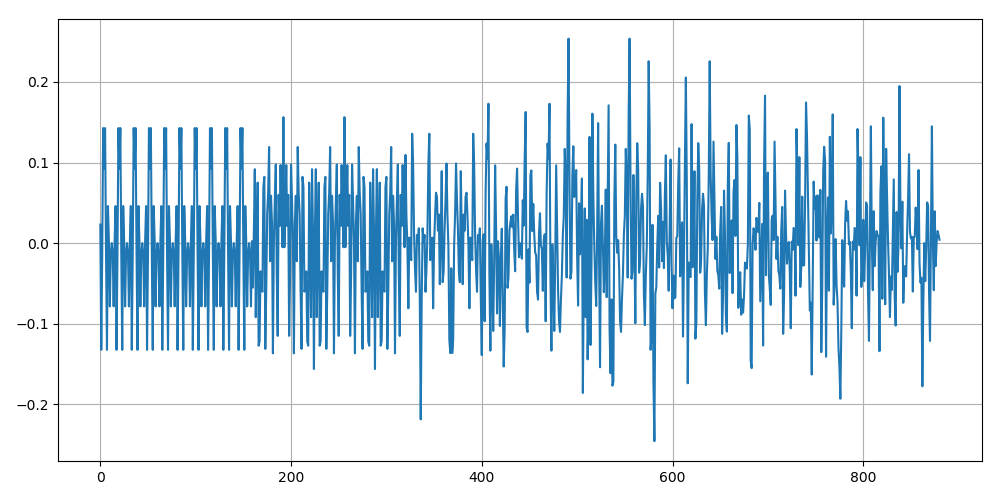

/home/gaspar/.local/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [43]:
data = '0x0402002E006008CD37A60020D6013CF1006008AD3BAF00004A6F792C2062726967687420737061726B206F6620646976696E6974792C0A4461756768746572206F6620456C797369756D2C0A466972652D696E73697265642077652074726561673321B6'
bits = flip_byte_endian(hex_to_bitstr(data))

tx = build_package(bits, data_rate=36)
# head = (np.random.normal(size=100) + np.random.normal(size=100)*1j) * 0.01

# tx = np.concatenate([head, tx])

# channel = (np.random.normal(size=len(tx)) + np.random.normal(size=len(tx))*1j) * 0.01
# tx += channel

plt.figure(figsize=(10,5))
plt.plot(tx)
plt.tight_layout()
plt.grid()

# Packet detector

/usr/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


<IPython.core.display.Javascript object>


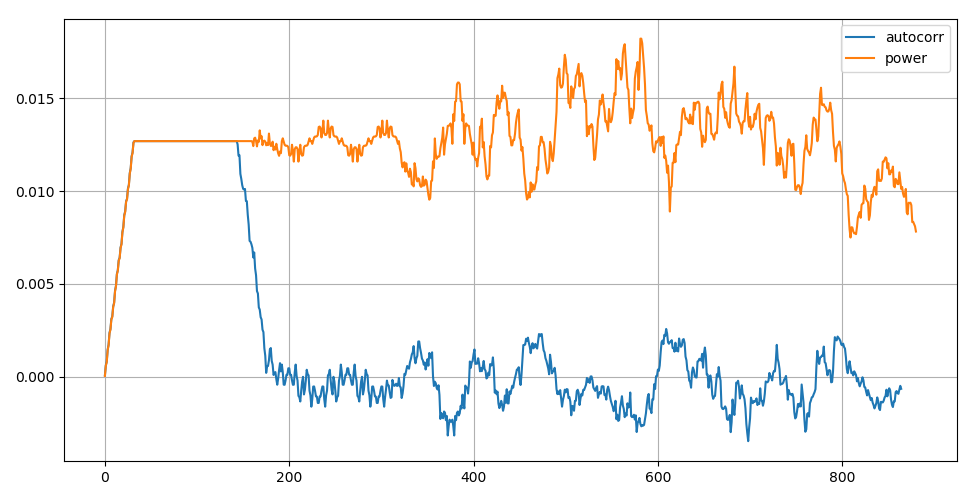

<IPython.core.display.Javascript object>


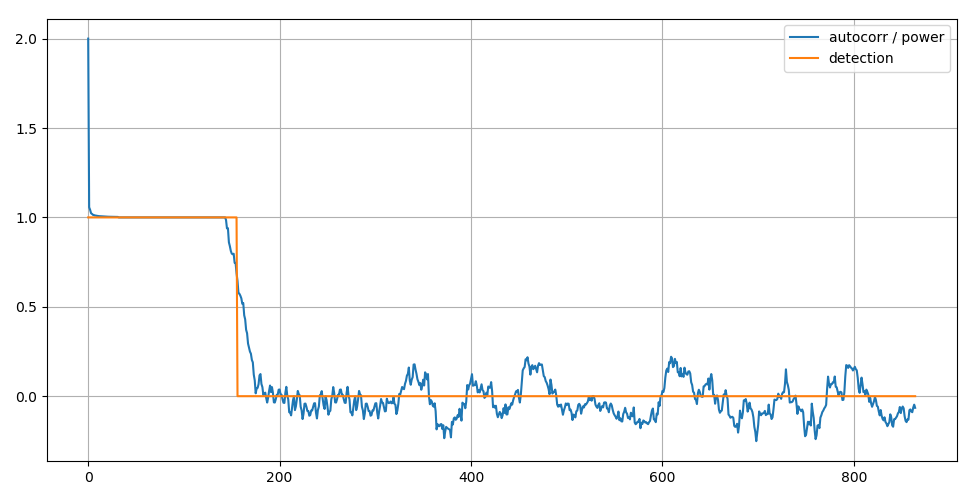

Falling edge position:  155


In [44]:

def average(inputs, window_len):
    taps = [1 / window_len] * window_len
    return signal.lfilter(taps, [1.0], inputs)

input = tx
mult = input[:-16] * np.conjugate(input[16:])
avg = average(mult, 32)
autocorr = avg.real

tmp = (input * np.conjugate(input)).real
avg = average(tmp, 32)
power = avg

plt.figure(figsize=(9.75,5))
plt.plot(autocorr, label='autocorr')
plt.plot(power, label='power')
plt.legend()
plt.tight_layout()
plt.grid()


ratio = np.array(autocorr / power[:len(autocorr)])

detection = 0
det = []
for i in range(len(ratio)):
    if ratio[i] > 0.85:
        detection = 1
    elif ratio[i] < 0.65:
        detection = 0
    det.append(detection)

plt.figure(figsize=(9.75,5))
plt.plot(ratio, label='autocorr / power')
plt.plot(det, label='detection')
plt.legend()
plt.tight_layout()
plt.grid()

falling_edge_i = np.where(np.diff(det) == -1)[0][0]
print('Falling edge position: ', falling_edge_i)

# TODO: Freq correction

# Timing acquisition

256


/usr/lib/python3.7/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


<IPython.core.display.Javascript object>


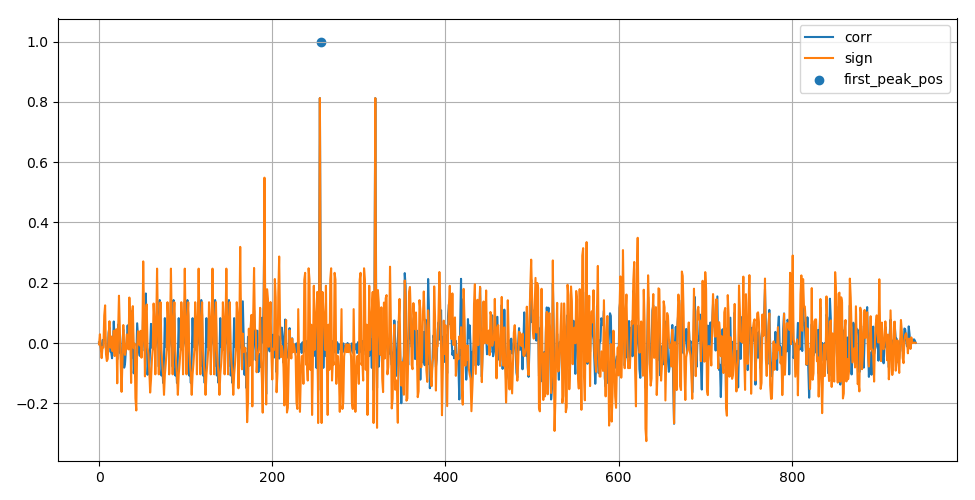

256


/home/gaspar/.local/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


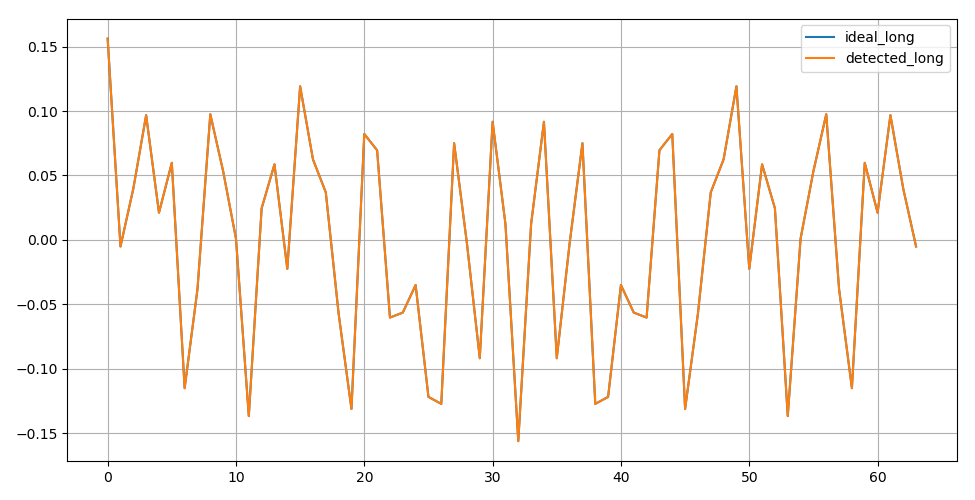

In [50]:
from ieee80211phy.transmitter.preamble import long_train_symbol
import scipy
long_symbol = long_train_symbol()
corr = scipy.signal.correlate(input, long_symbol)
corr_sign = scipy.signal.correlate(input, np.sign(long_symbol))
corr_sign /= corr_sign.max() / corr.max()

# skip over the first 'halfpeak' - whcih is from guard interval!
long_training_peak = np.argmax(corr[falling_edge_i+54: falling_edge_i+54+64]) + falling_edge_i+54 + 1
print(long_training_peak)

plt.figure(figsize=(9.75,5))
plt.plot(corr, label='corr')
plt.plot(corr_sign, label='sign')
plt.scatter([long_training_peak], [1.0], label='first_peak_pos')
# plt.xlim([0, 500])
plt.legend()
plt.tight_layout()
plt.grid()

# short_len = 160
# gi = 32
print(160+32+64)

plt.figure(figsize=(9.75,5))
plt.plot(long_symbol, label='ideal_long')
plt.plot(input[long_training_peak-64:long_training_peak], label='detected_long')
plt.legend()
plt.tight_layout()
plt.grid()


/usr/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


<IPython.core.display.Javascript object>


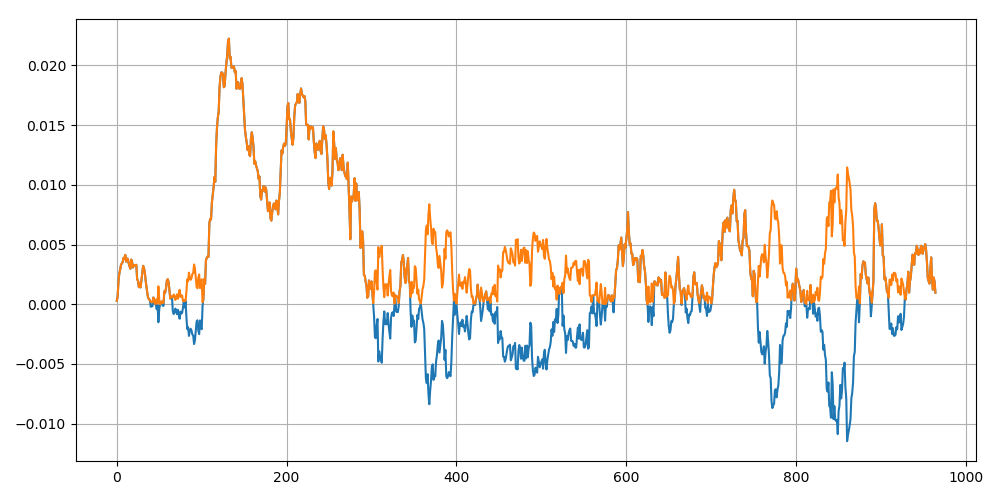

In [65]:
def average(inputs, window_len):
    taps = [1 / window_len] * window_len
    return signal.lfilter(taps, [1.0], inputs)

mult = tx[:-16] * np.conjugate(tx[16:])
avg = average(mult, 32)
autocorr = avg.real

mult = tx[:-16] * np.conjugate(tx[16:])
avg = average(mult.real, 32)
autocorr2 = np.abs(avg)

plt.figure(figsize=(10,5))
plt.plot(autocorr)
plt.plot(autocorr2)
plt.tight_layout()
plt.grid()

/usr/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


<IPython.core.display.Javascript object>


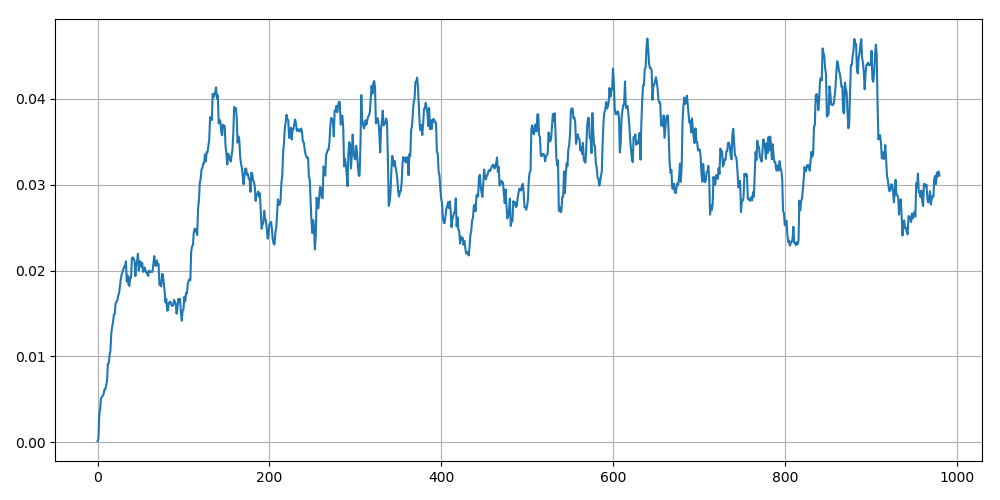

In [66]:
tmp = (tx * np.conjugate(tx)).real
avg = average(tmp, 32)
power = avg

plt.figure(figsize=(10,5))
plt.plot(power)
plt.tight_layout()
plt.grid()

<IPython.core.display.Javascript object>


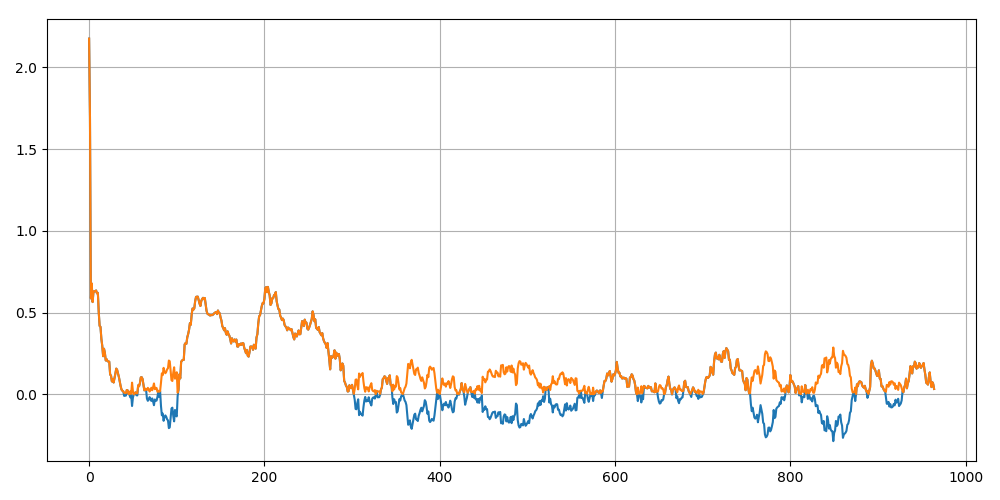

In [67]:
ratio = autocorr / power[:len(autocorr)]
ratio2 = autocorr2 / power[:len(autocorr2)]
plt.figure(figsize=(10,5))
plt.plot(ratio)
plt.plot(ratio2)
plt.tight_layout()
plt.grid()